In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from alive_progress import alive_bar
from keras.datasets import mnist

In [4]:
def vectorised_result(x):
    vec = np.zeros((10,1))
    vec[x] = 1
    return vec

In [5]:
def creating_data():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    train_X = [np.reshape(x, (784, 1)) for x in train_X]
    train_X = [x/255.0 for x in train_X]
    train_y = [vectorised_result(y) for y in train_y]

    test_X = [np.reshape(x, (784, 1)) for x in test_X]
    test_X = [x/255.0 for x in test_X]
    test_y = [vectorised_result(y) for y in test_y]

    training_data = list(zip(train_X, train_y))
    test_data = list(zip(test_X, test_y))

    return training_data, test_data

In [6]:
training_data, test_data = creating_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
class Network(object):

    def __init__(self, sizes):
        ''' sizes = [784,30,10] means three nerual layers with indexes as there number of nodes'''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(size, 1) for size in sizes[1:]]
        self.weights = [np.random.randn(x, y)
                        for x, y in zip(sizes[1:], sizes[:-1])]
        self.train_loss = []
        self.test_loss = []

    def sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))

    def sigmoid_prime(self, x):
        sig = self.sigmoid(x)
        return sig*(1-sig)

    def forwardprop(self, a):
        '''Returns the output'''
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs=10, mini_batch_size=10, learning_rate=0.01, regulariser=0.0, test_data=None):
        '''Find the best parameters'''
        if test_data:
            test_data_size = len(test_data)
        training_data_size = len(training_data)

        print("By Random Initialisation:")
        self.train_test_loss(training_data=training_data)
        if test_data:
            self.train_test_loss(test_data=test_data)

        for j in range(epochs):
            print(f"Epoch {j}:")
            random.shuffle(training_data)

            mini_batches = [training_data[k:k+mini_batch_size] 
                            for k in range(0, training_data_size, mini_batch_size)]

            mini_batches_size = len(mini_batches)

            with alive_bar(mini_batches_size, force_tty=True) as bar:
                for mini_batch in mini_batches:
                    bar()
                    self.update_mini_batch(mini_batch, learning_rate,training_data_size,regulariser)

            self.train_test_loss(training_data=training_data)
            if test_data:
                self.train_test_loss(test_data=test_data)

    def update_mini_batch(self, mini_batch, learning_rate,training_data_size,regulariser):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.weights = [w*(1-regulariser*(learning_rate/training_data_size)) - (learning_rate/len(mini_batch))
                        * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate/len(mini_batch))
                       * nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = self.loss_function_prime(activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for layer in range(2, self.num_layers):
            z = zs[-layer]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-layer + 1].transpose(), delta)*sp

            nabla_b[-layer] = delta
            nabla_w[-layer] = np.dot(delta,
                                     activations[-layer - 1].transpose())

        return nabla_b, nabla_w

    def loss_function(self, activation_output, y):
        return np.sum(np.nan_to_num(-y*np.log(activation_output)-(1-y)*np.log(1-activation_output)))

    def loss_function_prime(self, activation_output, y):
        return activation_output - y

    def squared_norm(self, x):
        norm_x = [xi**2 for xi in x]
        return sum(norm_x)
    
    def train_test_loss(self,training_data = None, test_data = None):
        if training_data:
            trained_results = [(self.forwardprop(x), y) for (x, y) in training_data]
            training_loss = [self.loss_function(x, y) for (x, y) in trained_results]

            net_training_loss = 1.0*np.sum(training_loss)/len(training_data)

            print(f"  Training Loss: {net_training_loss}")

            self.train_loss.append(net_training_loss)

            print(f"  Training Fraction: {self.evaluate(trained_results)}/ {len(training_data)}")
        
        else:
            test_results = [(self.forwardprop(x), y) for (x, y) in test_data]
            test_loss = [self.loss_function(x, y) for (x, y) in test_results]

            net_test_loss = 1.0*np.sum(test_loss)/len(test_data)

            print(f"  Test Loss: {net_test_loss}")

            self.test_loss.append(net_test_loss)

            print(f"  Test Fraction: {self.evaluate(test_results)}/ {len(test_data)}")
    
    def evaluate(self, data_results):
        predictions = [(np.argmax(x), np.argmax(y)) for (x, y) in data_results]
        return sum(int(x == y) for (x, y) in predictions)

    def plotting_loss(self):
        x1 = np.arange(0, len(self.train_loss))
        x2 = np.arange(0,len(self.test_loss))
        plt.title("Training and Testing Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")

        plt.plot(x1, self.train_loss, linestyle='--', color="teal", label="Train Loss")
        plt.plot(x2, self.test_loss, linestyle='--', color="darkkhaki", label="Test Loss")
        plt.legend()
        plt.show()

In [8]:
net = Network([784, 30, 10])

In [9]:
net.SGD(training_data=training_data, epochs=5, mini_batch_size=10, learning_rate=0.5, regulariser=5.0, test_data=test_data)

By Random Initialisation:
  Training Loss: 16.902077371154355
  Training Fraction: 4717/ 60000
  Test Loss: 16.95251558653392
  Test Fraction: 752/ 10000
Epoch 0:
|████████████████████████████████████████| 6000/6000 [100%] in 7.5s (796.31/s)                                          
  Training Loss: 0.4949222701228462
  Training Fraction: 55645/ 60000
  Test Loss: 0.502911359287664
  Test Fraction: 9252/ 10000
Epoch 1:
|████████████████████████████████████████| 6000/6000 [100%] in 7.7s (782.09/s)                                          
  Training Loss: 0.3944846688154776
  Training Fraction: 56506/ 60000
  Test Loss: 0.42150061184126414
  Test Fraction: 9363/ 10000
Epoch 2:
|████████████████████████████████████████| 6000/6000 [100%] in 8.5s (710.03/s)                                          
  Training Loss: 0.3652358985751641
  Training Fraction: 56917/ 60000
  Test Loss: 0.38891592047898454
  Test Fraction: 9435/ 10000
Epoch 3:
|████████████████████████████████████████| 6000/6000 

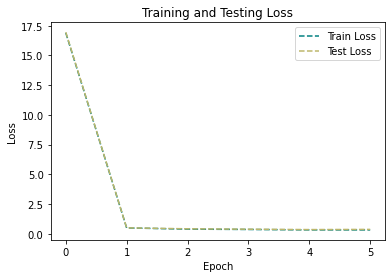

In [10]:
net.plotting_loss()